
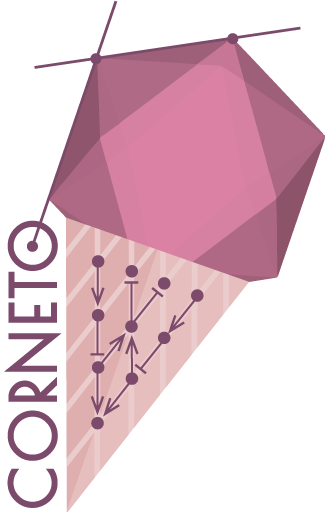

In [15]:
import pandas as pd
import cptac as cp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc
import corneto as cn
from corneto.graph import Graph
from corneto.data import Data
from corneto.methods.future.carnival import CarnivalFlow, CarnivalILP
from corneto.contrib.networkx import corneto_graph_to_networkx
from corneto.methods.signalling.carnival import multi_carnival
cn.info()

In [16]:
# load prior knowledge: Biological entities of interest (receptors, kinases, TFs), and regulons for TF and Kinase activity analysis
receptors = pd.read_csv('https://raw.githubusercontent.com/saezlab/liana-py/refs/heads/main/liana/resource/omni_resource.csv')
receptors = set(receptors[receptors['resource'] == 'consensus']['target_genesymbol'])
kinases = set(pd.read_csv('https://raw.githubusercontent.com/esbgkannan/phosformer/refs/heads/main/data/reference_human_kinases.csv').gene)
collectri = pd.read_csv('https://zenodo.org/records/8192729/files/CollecTRI_regulons.csv')
tfs = set(collectri.source)
all_genes = receptors.union(kinases).union(tfs)

# load phospho regulons
psiteplus = pd.read_csv('https://omnipathdb.org/enz_sub?genesymbols=1', sep = '\t')
psiteplus_todc = psiteplus[psiteplus['modification'] == 'phosphorylation'].copy()
psiteplus_todc = psiteplus_todc[['enzyme_genesymbol', 'substrate_genesymbol', 'residue_type','residue_offset']]
psiteplus_todc = psiteplus_todc[~psiteplus_todc['substrate_genesymbol'].isin(tfs)]
psiteplus_todc['target'] = psiteplus_todc['substrate_genesymbol'] + '_' + psiteplus_todc['residue_type'] + psiteplus_todc['residue_offset'].astype(str)
psiteplus_todc = psiteplus_todc[['enzyme_genesymbol', 'target']].rename(columns = {'enzyme_genesymbol':'source'}).drop_duplicates()
psiteplus_todc['weight'] = 1

# load signaling PPI network
omnipath = pd.read_csv('https://omnipathdb.org/interactions/?genesymbols=1', sep='\t')
omnipath = omnipath[omnipath['is_directed'] == 1]
omnipath['sign'] = np.where(omnipath['consensus_stimulation'] == 1, 1, np.where(omnipath['consensus_inhibition'] == 1, -1, 0))
omnipath = omnipath[omnipath['sign'] != 0]
omnipath = omnipath[omnipath['source_genesymbol'] != omnipath['target_genesymbol']]
omnipath = omnipath[['source_genesymbol', 'target_genesymbol', 'sign']].rename(columns={'source_genesymbol': 'source', 'target_genesymbol': 'target'})
omnipath

,source,target,sign
0,CALM1,TRPC1,-1
1,CALM3,TRPC1,-1
2,CALM2,TRPC1,-1
3,CAV1,TRPC1,1
4,DRD2,TRPC1,1
...,...,...,...
81463,SYK,NFKBIA,1
81476,MAPK3,GATA4,1
81487,GRK5,CXCR4,1
81488,SLK,RHOA,-1


In [17]:
# load and compute per patient differential profiles using the LUAD cptac dataset
lu = cp.Luad()
print(lu.list_data_sources())
som_muts = lu.get_somatic_mutation('harmonized')
transcriptomics = lu.get_transcriptomics('bcm')
pp = lu.get_phosphoproteomics('umich')

def compute_diff(input_df):
    sample_list = list(input_df.columns)
    normal_samples = {s[:-2]: s for s in sample_list if s.endswith('.N')}
    tumor_samples = [s for s in sample_list if not s.endswith('.N')]
    tumor_to_normal = {tumor: normal_samples[tumor] for tumor in tumor_samples if tumor in normal_samples}
    print("Tumor to Normal Matches:", len(tumor_to_normal))
    print("Unmatched Tumor Samples:", len(tumor_samples) - len(tumor_to_normal))

    # for each patient, compute difference between tumor and normal
    diffs = []
    for tumor, normal in tumor_to_normal.items():
        diff = input_df[tumor] / input_df[normal]
        diffs.append(diff)

    diff_df = pd.concat(diffs, axis=1)
    diff_df.columns = tumor_to_normal.keys()

    # set infs, 0s, and nans to np.nan
    diff_df = diff_df.replace([np.inf, -np.inf], np.nan)
    diff_df = diff_df.replace(0, np.nan)
    diff_df = diff_df.replace(np.nan, np.nan)
    diff_df = np.log2(diff_df)

    return diff_df
rna_diff = compute_diff(transcriptomics.T)
rna_diff = rna_diff.groupby(level=0).mean()
pp_diff = compute_diff(pp.T)
pp_diff = pp_diff.groupby(level=[0, 1]).mean()
pp_diff.index = pp_diff.index.map('_'.join)

              Data type    Available sources
0                   CNV         [bcm, washu]
1          circular_RNA                [bcm]
2                 miRNA         [bcm, washu]
3     phosphoproteomics         [bcm, umich]
4            proteomics         [bcm, umich]
5       transcriptomics  [bcm, broad, washu]
6   ancestry_prediction         [harmonized]
7      somatic_mutation  [harmonized, washu]
8              clinical               [mssm]
9             follow-up               [mssm]
10      medical_history               [mssm]
11     acetylproteomics              [umich]
12            cibersort              [washu]
13           hla_typing              [washu]
14         tumor_purity              [washu]
15                xcell              [washu]
Tumor to Normal Matches: 102
Unmatched Tumor Samples: 9
Tumor to Normal Matches: 102
Unmatched Tumor Samples: 9


/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


In [18]:
# run kinase and tf activity inerence analysis
dc_input = rna_diff.copy()
dc_input = dc_input.fillna(0)
tf_diff = dc.run_ulm(mat = dc_input.T, net = collectri)
tf_diff = pd.DataFrame(tf_diff[0]).T
pp_dc_input = pp_diff.copy()
pp_dc_input = pp_dc_input.fillna(0)
kin_diff = dc.run_ulm(mat = pp_dc_input.T, net = psiteplus_todc)
kin_diff = pd.DataFrame(kin_diff[0]).T
common_patients = set(tf_diff.columns).intersection(set(pp_diff.columns))

In [19]:
# select patients for the analysis: Those with the higuest mutational burden assuming more likely deregulated signaling pathways
int_mutations = ['Missense_Mutation', 'Nonsense_Mutation', 'Frame_Shift_Del', 'Frame_Shift_Ins']
filt_muts = som_muts[som_muts.Mutation.isin(int_mutations)]
filt_muts = filt_muts[['Gene','Tumor_Sample_Barcode']].drop_duplicates()
filt_muts['mutated'] = 1
filt_muts = filt_muts.pivot(index='Gene', columns='Tumor_Sample_Barcode', values='mutated').fillna(0)
filt_muts.columns = filt_muts.columns.str.replace('_T', '')
gen_patients = list(set(filt_muts.columns).intersection(common_patients))
filt_muts = filt_muts[gen_patients]

# compute total muts
mut_sum = filt_muts.sum(axis=0)
mut_sum = mut_sum.sort_values(ascending=False)

# selected patients are the top 10% of patients with the most mutations
top_patients = mut_sum[mut_sum >= mut_sum.quantile(0.9)].index
print(len(top_patients))
top_muts = filt_muts[top_patients]

10


In [20]:
receptor_df = pp_diff[pp_diff.index.isin(receptors)].copy()
kinase_df = kin_diff[kin_diff.index.isin(kinases)].copy()
tf_df = tf_diff[tf_diff.index.isin(tfs)].copy()
# restrict to top patients
receptor_df = receptor_df[top_patients]
kinase_df = kinase_df[top_patients]
tf_df = tf_df[top_patients]

In [21]:
# create CORNETO graph
to_corneto_ppi = omnipath.copy()
to_corneto_ppi = to_corneto_ppi[to_corneto_ppi.source.isin(kinase_df.index)]
to_corneto_ppi = to_corneto_ppi[to_corneto_ppi.target.isin(set(kinase_df.index).union(set(tf_df.index)))]
to_corneto_ppi = pd.concat([to_corneto_ppi, pd.DataFrame({'source': 'cancer', 'target': to_corneto_ppi.source.unique(), 'sign': 1})])
G = Graph.from_tuples(to_corneto_ppi[['source','sign', 'target' ]].apply(tuple, axis=1).values)
G 

In [22]:
# subset to nodes in the network
receptor_df_filt = receptor_df[receptor_df.index.isin(G.vertices)]
kinase_df_filt = kinase_df[kinase_df.index.isin(G.vertices)]
tf_df_filt = tf_df[tf_df.index.isin(G.vertices)]

In [23]:
# create patient_data dict which contains, for each patient (using column ID)
patient_data = {}
for patient in top_patients:
    patient_data[patient] = {}
    patient_data[patient]['input'] = {'cancer': 0}
    patient_data[patient]['output'] = {}
    patient_data[patient]['output'].update(tf_df_filt[patient].to_dict())

In [35]:
results = []
edges = []
vertices = []

for seed in range(30):
    print(seed)
    P_multi, G_multi, summary = multi_carnival(G, patient_data, lambd=0.8)
    P_multi.solve(solver="GUROBI", Seed=seed, IntegralityFocus=1, NoRelHeurTime=60, verbosity=0, TimeLimit=180, MIPGap=0.01)
    edges.append(P_multi.expr.edge_value.value)
    vertices.append(P_multi.expr.vertex_value.value)   

0


/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [78]:
df_mean_edges = pd.DataFrame(np.mean(edges, axis=0), index=G_multi.E, columns=list(patient_data.keys()))
df_mean_vertices = pd.DataFrame(np.mean(vertices, axis=0), index=G_multi.V, columns=list(patient_data.keys()))
df_mean_vertices

,C3L-00144,C3N-00175,C3N-00560,C3N-02089,C3N-00580,C3L-00095,C3N-01030,C3N-01489,C3L-00080,C3L-00279
HDAC7,-0.900000,-0.666667,0.9,0.033333,1.000000,1.000000,-1.000000,0.800000,1.000000,1.000000
NOTCH1,1.000000,-1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-0.866667
MITF,-0.700000,-0.433333,-0.8,-1.000000,-0.466667,1.000000,-0.366667,0.000000,-0.200000,-0.800000
ESR1,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000
BCL3,-0.333333,-0.933333,-0.2,0.000000,-0.533333,-1.000000,-1.000000,-1.000000,-0.800000,-0.200000
...,...,...,...,...,...,...,...,...,...,...
PGR,0.666667,-1.000000,-1.0,0.700000,-1.000000,0.700000,0.300000,0.800000,-1.000000,-1.000000
YBX1,1.000000,1.000000,0.0,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
NCOA3,1.000000,1.000000,1.0,1.000000,1.000000,0.966667,0.966667,0.966667,-0.966667,-1.000000
PA2G4,0.000000,0.100000,0.1,0.133333,0.000000,0.000000,-0.033333,-0.033333,-0.133333,-0.133333


In [79]:
import pickle

with open("sol_edges_lam0.8.pkl", "wb") as file:
    pickle.dump(edges, file)

with open("sol_vertices_lam0.8.pkl", "wb") as file:
    pickle.dump(vertices, file)

In [80]:
G_multi.save("sol_graph")

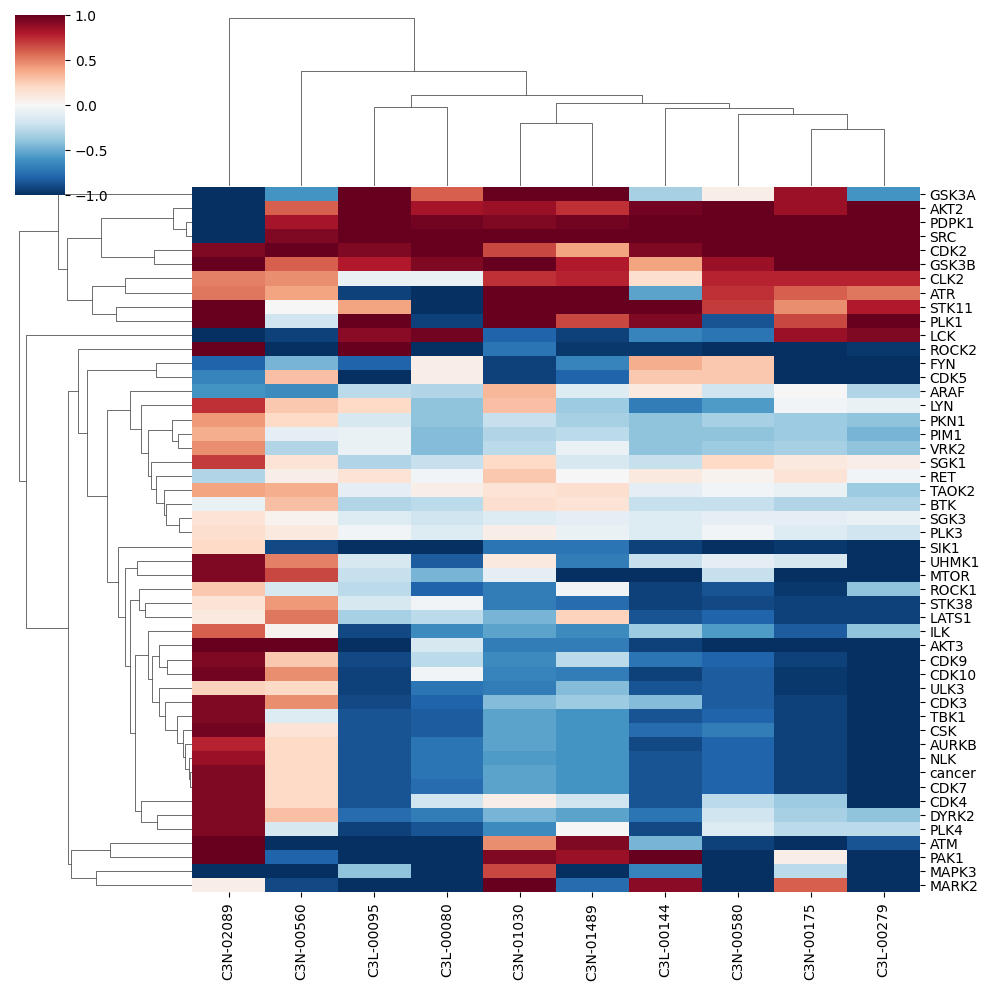

In [280]:
df_mean_vertices_pred = df_mean_vertices.loc[df_mean_vertices.index.difference(tf_df_filt.index)]
df_mean_vertices_pred = df_mean_vertices_pred.loc[df_mean_vertices_pred.std(axis=1).sort_values().tail(50).index]
sns.clustermap(df_mean_vertices_pred, cmap="RdBu_r", center=0, yticklabels=True)

In [281]:
exclude = tf_df_filt.index.tolist() + ["cancer"]

In [282]:
mask = ~df_mean_edges.index.get_level_values(1).map(lambda x: next(iter(x)) if x else None).isin(exclude)
df_mean_pred_edges = df_mean_edges[mask]
df_mean_pred_edges

,,C3L-00144,C3N-00175,C3N-00560,C3N-02089,C3N-00580,C3L-00095,C3N-01030,C3N-01489,C3L-00080,C3L-00279
(ABL1),(PRKDC),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.033333,-0.033333,0.000000,0.000000
(PDPK1),(PAK1),0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000
(MTOR),(ULK1),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
(ROCK1),(DAPK3),-0.033333,-0.033333,-0.033333,0.033333,-0.033333,-0.033333,0.033333,0.033333,-0.033333,-0.033333
(ATM),(STK11),0.266667,-0.133333,-0.500000,0.566667,-0.100000,-0.166667,0.633333,0.366667,-0.800000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
(PGR),(),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
(YBX1),(),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
(NCOA3),(),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
(PA2G4),(),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [283]:
def extract_protein(fset):
    # If the frozenset is empty, return "input"
    if not fset:
        return "input"
    # Extract the single protein name
    protein = next(iter(fset))
    # If the protein is "cancer", return "input"
    if protein.lower() == "cancer":
        return "input"
    return protein

# Create a new index by processing each level in the MultiIndex
new_index = [
    f"{extract_protein(level0)}-{extract_protein(level1)}"
    for level0, level1 in df_mean_pred_edges.index
]

# Assign the new single-level index to the DataFrame
df_mean_pred_edges.index = new_index
df_mean_pred_edges

,C3L-00144,C3N-00175,C3N-00560,C3N-02089,C3N-00580,C3L-00095,C3N-01030,C3N-01489,C3L-00080,C3L-00279
ABL1-PRKDC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.033333,-0.033333,0.000000,0.000000
PDPK1-PAK1,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000
MTOR-ULK1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ROCK1-DAPK3,-0.033333,-0.033333,-0.033333,0.033333,-0.033333,-0.033333,0.033333,0.033333,-0.033333,-0.033333
ATM-STK11,0.266667,-0.133333,-0.500000,0.566667,-0.100000,-0.166667,0.633333,0.366667,-0.800000,0.000000
...,...,...,...,...,...,...,...,...,...,...
PGR-input,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
YBX1-input,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NCOA3-input,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PA2G4-input,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [284]:
df_mean_pred_edges = df_mean_pred_edges[~df_mean_pred_edges.index.str.contains("input")]
df_mean_pred_edges = df_mean_pred_edges.loc[df_mean_pred_edges.std(axis=1).sort_values().tail(50).index]
df_mean_pred_edges

,C3L-00144,C3N-00175,C3N-00560,C3N-02089,C3N-00580,C3L-00095,C3N-01030,C3N-01489,C3L-00080,C3L-00279
NUAK1-LATS1,0.000000,0.000000,0.133333,-0.100000,0.000000,0.133333,0.000000,0.166667,0.133333,0.000000
STK11-GSK3B,0.133333,0.200000,0.100000,0.166667,0.266667,0.233333,0.300000,0.200000,0.000000,0.233333
SGK3-GSK3A,0.066667,0.100000,-0.033333,-0.133333,0.066667,0.133333,0.133333,0.133333,0.166667,0.033333
AKT1-CDK2,0.966667,1.000000,0.900000,0.866667,1.000000,0.933333,0.833333,0.700000,0.933333,0.966667
GSK3B-CDK1,-0.666667,-0.833333,-0.766667,-1.000000,-0.833333,-0.733333,-0.800000,-0.700000,-0.800000,-0.766667
TBK1-AKT1,0.000000,0.000000,0.066667,0.300000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000
FYN-LCK,-0.100000,0.000000,-0.200000,-0.100000,-0.100000,0.033333,-0.200000,-0.200000,0.033333,0.000000
PDPK1-AKT1,0.333333,0.300000,0.233333,0.000000,0.266667,0.333333,0.233333,0.300000,0.300000,0.300000
ABL1-CDK5,-0.166667,-0.233333,0.000000,-0.266667,-0.166667,-0.366667,-0.233333,-0.233333,-0.166667,-0.300000
ABL1-MTOR,-0.166667,-0.166667,0.133333,-0.033333,-0.100000,-0.133333,-0.133333,-0.233333,-0.100000,-0.133333


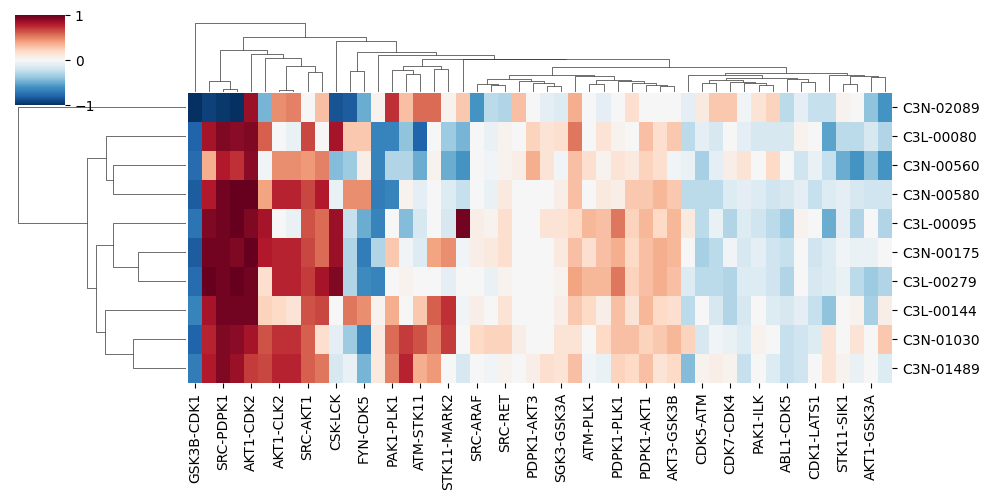

In [285]:
#fig, ax = plt.subplots(figsize=(4,8))
sns.clustermap(df_mean_pred_edges.T, cmap="RdBu_r", center=0, yticklabels=True, figsize=(10,5))
plt.savefig("cluster_interactions.svg")

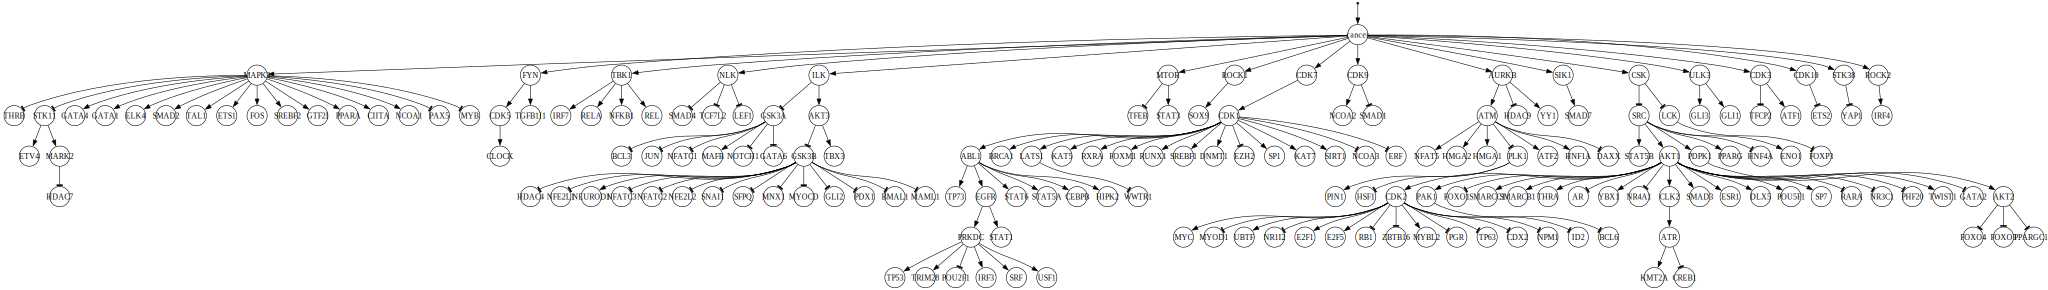

In [286]:
df_is_sel_seed0 = pd.DataFrame(np.abs(edges[0])>0, index=G_multi.E, columns=list(patient_data.keys()))
G_multi.edge_subgraph(np.flatnonzero(df_is_sel_seed0["C3N-00175"].values)).plot()

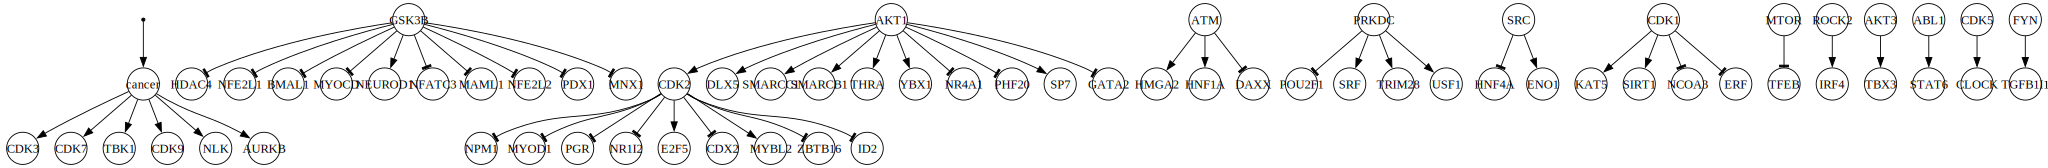

In [287]:
df_is_selected = pd.DataFrame(np.mean(np.abs(edges), axis=0)>=1, index=G_multi.E, columns=list(patient_data.keys()))
G_multi.edge_subgraph(np.flatnonzero(df_is_selected["C3N-00175"].values)).plot()

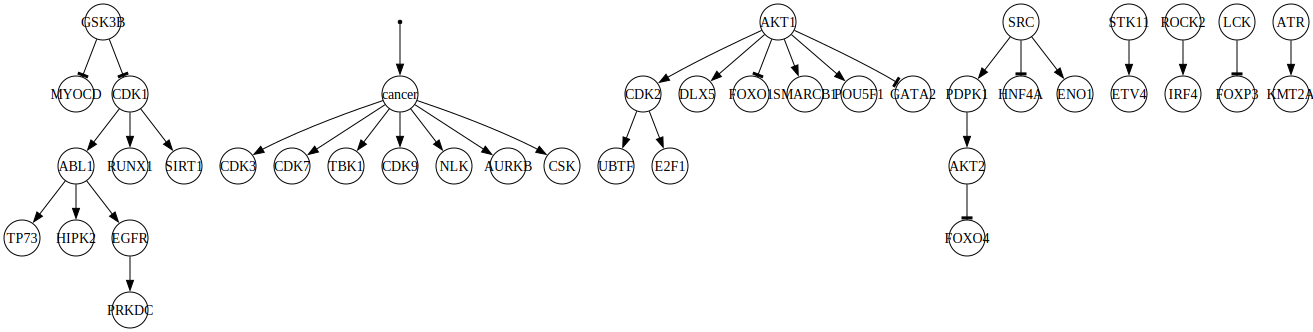

In [288]:
common_edges = np.flatnonzero((pd.DataFrame(np.mean(np.abs(edges), axis=0) >= 0.5, index=G_multi.E).mean(axis=1) == 1).values)
G_multi.edge_subgraph(common_edges).plot()

In [293]:
df_intersections = pd.DataFrame(np.mean([(np.mean(np.abs(e), axis=1)==1) for e in edges], axis=0), index=G_multi.E)
g_int = G_multi.edge_subgraph(np.flatnonzero(df_intersections>0.5))
dot = g_int.to_graphviz()

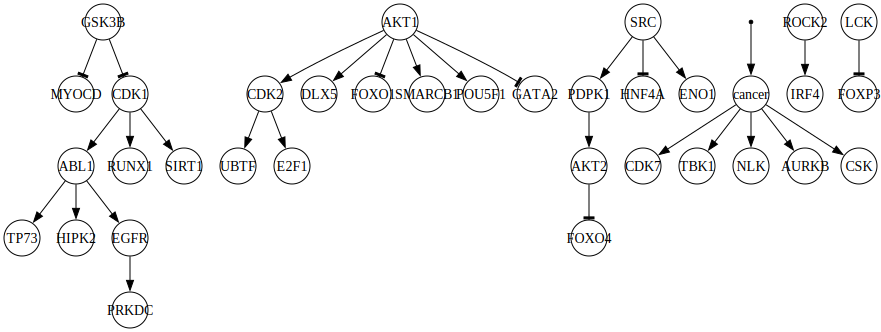

In [294]:
dot

In [327]:
tfs = dict()
for k, v in patient_data.items():
    for tf, val in v["output"].items():
        if tf not in g_int.V:
            continue
        vals = tfs.get(tf, [])
        vals.append(val)
        tfs[tf] = vals
        c = tf_counter.get(tf, 0)
        
node_values = dict()
for tf, val in tfs.items():
    print(tf, np.median(val), np.std(val))
    node_values[tf] = np.mean(val)

ABL1 -0.28333108127117157 0.12152250817579106
DLX5 0.7626519203186035 0.8926521614693053
E2F1 2.846149444580078 1.18499996417961
ENO1 0.8519818484783173 0.5487040743964663
FOXO1 -1.7808144092559814 0.7150916630659614
FOXO4 -0.9388654828071594 0.7663713753403552
FOXP3 0.05967681296169758 0.5787170406884975
GATA2 -2.2284892797470093 0.8439509971166806
HIPK2 -0.6677616834640503 0.3541136911115697
HNF4A -1.5847349166870117 1.3933442536537266
IRF4 -0.5008032470941544 0.7831828669016384
MYOCD -1.7326757907867432 1.0084477990874074
POU5F1 0.7380266189575195 0.30169495784882255
RUNX1 -2.100952684879303 0.5476859297383672
SIRT1 -0.4632979929447174 0.579835040580339
SMARCB1 0.6961612105369568 0.42864758630872973
TP73 -1.0658358335494995 0.7352105162344806
UBTF 1.2262730598449707 0.6725029135218541


In [328]:
kin = set(pd.read_csv("kinases_filt.csv", index_col=0).index.values.tolist())

/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_1340/615295617.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


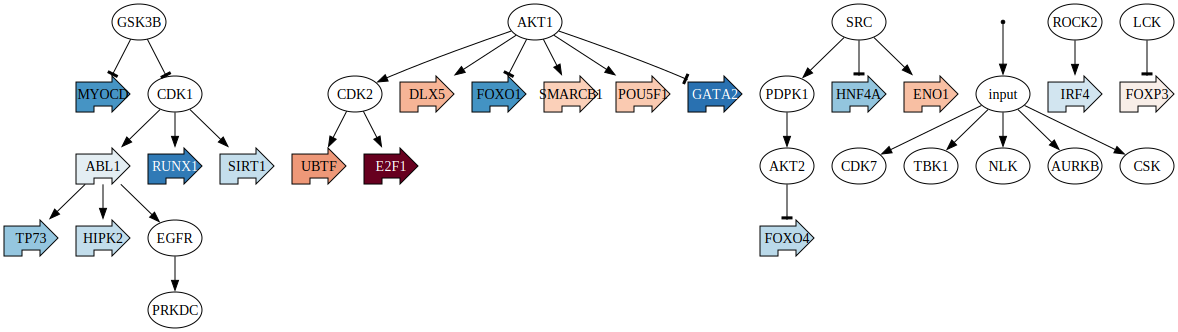

In [329]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Create a symmetric normalization based on the maximum absolute value.
abs_max = max(abs(val) for val in node_values.values())
norm = colors.Normalize(vmin=-abs_max, vmax=abs_max)

# Get the RdBu colormap.
cmap = cm.get_cmap('RdBu_r')

# Helper function to convert an RGBA color (values 0-1) to a hex string.
def rgba_to_hex(rgba):
    return '#{:02x}{:02x}{:02x}'.format(
        int(rgba[0] * 255),
        int(rgba[1] * 255),
        int(rgba[2] * 255)
    )

# Helper function to decide the font color based on the fill color's brightness.
def get_font_color(rgba, threshold=0.5):
    r, g, b, _ = rgba
    # Standard luminance calculation.
    brightness = 0.299 * r + 0.587 * g + 0.114 * b
    return 'white' if brightness < threshold else 'black'



# First, update nodes that are in the dictionary.
for node, value in node_values.items():
    # Compute the color for the node.
    rgba = cmap(norm(value))
    hex_color = rgba_to_hex(rgba)
    
    # Choose font color based on brightness.
    font_color = get_font_color(rgba)
    
    # For nodes in the dictionary, set shape to "rpromoter".
    dot.node(node, label=node, style='filled', fillcolor=hex_color,
             shape='rpromoter', fontcolor=font_color)


# For nodes not in your TF set, if they were not updated above (i.e. still have the default circle shape),
# re-add them with shape set to ellipse.
for node in g_int.V:
    if node not in node_values:
        # Re-add node with ellipse shape.
        label = node if str(node) != "cancer" else "input"
        dot.node(node, label=label, shape='ellipse')

dot

In [330]:
dot.render('intersection')

'intersection.pdf'

In [331]:
with open("intersection.viz", "w") as file:
    file.write(dot.source)

In [332]:
set(g_int.V).intersection(kin)

{'ABL1',
 'AKT1',
 'AKT2',
 'AURKB',
 'CDK1',
 'CDK2',
 'CDK7',
 'CSK',
 'EGFR',
 'GSK3B',
 'LCK',
 'NLK',
 'PDPK1',
 'PRKDC',
 'ROCK2',
 'SRC',
 'TBK1'}

/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_1340/4058046302.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')


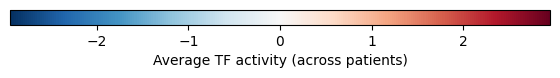

In [335]:
# Calculate the maximum absolute value.
abs_max = max(abs(val) for val in node_values.values())

# Create a normalization instance.
norm = colors.Normalize(vmin=-abs_max, vmax=abs_max)
cmap = cm.get_cmap('RdBu_r')

# Create a ScalarMappable and set its array to a non-empty range.
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(-abs_max, abs_max, 256))

# Create a new figure and define an axis for the colorbar.
fig = plt.figure(figsize=(6, 1))
cax = fig.add_axes([0.05, 0.4, 0.9, 0.15])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Average TF activity (across patients)')

plt.savefig("node_values.svg")
